In [2]:
# just here
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# imports
from copy import copy
import numpy as np
import pandas as pd
import pynapple as nap
import matplotlib.pyplot as plt
import iblphotometry.loaders as loaders
import iblphotometry.plots as plots

/home/georg/code/ONE/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [ ]:
# KCENIA / isosbestic specific
from one.api import ONE
one = ONE(cache_dir='/mnt/h0/kb/data/one')
data_loader = loaders.KceniaLoader(one, verbose=True)
df = pd.read_csv('/home/georg/code/ibl-photometry/src/local/website.csv')
eids = list(df['eid'])

In [75]:
eid = eids[4]
eid = 'b7b186ee-1b36-4b1a-ae15-70078c472f97'
raw_photometry, brain_regions = data_loader.load_photometry_data(eid, return_regions=True)
trials = one.load_dataset(eid, '*trials.table')

available signal bands: ['raw_calcium', 'raw_isosbestic']
available brain regions: ['Region4G']


/home/georg/code/ibl-photometry/src/iblphotometry/pipelines.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _d[:, i] = pipe_func(Fc[col], **pipe_args)
/home/georg/code/ibl-photometry/src/iblphotometry/pipelines.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _d[:, i] = pipe_func(Fc[col], **pipe_args)
/home/georg/code/ibl-photometry/src/iblphotometry/pipelines.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _d[:, i] = pipe_func(Fc[col], **pipe_args)
/home/georg/code/ibl-photometry/src/iblphotometry/pipelines.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing cop

<Axes: xlabel='time (s)', ylabel='signal (au)'>

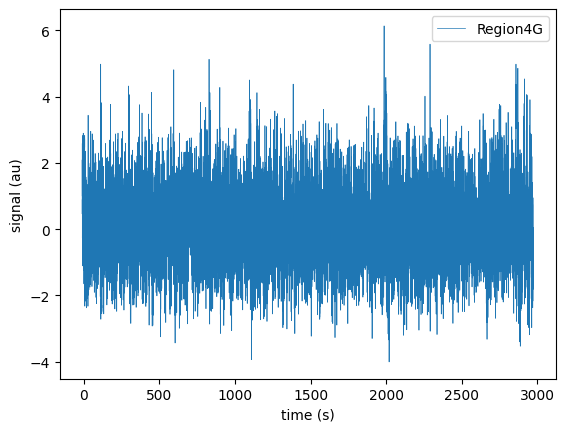

In [78]:
from iblphotometry.outlier_detection import remove_spikes
from iblphotometry.bleach_corrections import lowpass_bleachcorrect
from iblphotometry.bleach_corrections import isosbestic_correct
from iblphotometry.sliding_operations import sliding_mad
from iblphotometry.helpers import zscore
from iblphotometry.pipelines import run_pipeline

# pipeline = [
#       (remove_spikes, dict(sd=5)),
#       # (lowpass_bleachcorrect, dict(filter_params=dict(N=3, Wn=0.01, btype='lowpass'))),
#       (isosbestic_correct, dict(on_columns=False,
#                                 signal_name='raw_calcium',
#                                 reference_name='raw_isosbestic',
#                                 correction_method='subtract-divide',
#                               #   regression_method='huber',
#                                 lowpass_isosbestic=dict(N=3, Wn=0.01, btype='lowpass')),),
#       # (sliding_mad, dict(w_len=120,overlap=90)),

# ]

pipeline = [
    (remove_spikes, dict(sd=5)),
    (lowpass_bleachcorrect, dict(filter_params=dict(N=3, Wn=0.01, btype='lowpass'))),
    (sliding_mad, dict(w_len=120,overlap=90)),
    (zscore, dict(mode='median'))
]

# run pipeline
# restrict raw photometry to time within a session +- 10s
session_start_time = trials['intervals_0'].values[0] - 10
session_end_time = trials['intervals_1'].values[-1] + 10
interval = nap.IntervalSet(start=session_start_time, end=session_end_time)
_photometry = raw_photometry['raw_calcium'].restrict(interval)

photometry = run_pipeline(pipeline, _photometry)
plots.plot_TsdFrame(photometry)

array([<Axes: ylabel='feedbackType=-1'>,
       <Axes: xlabel='time (s)', ylabel='feedbackType=1'>], dtype=object)

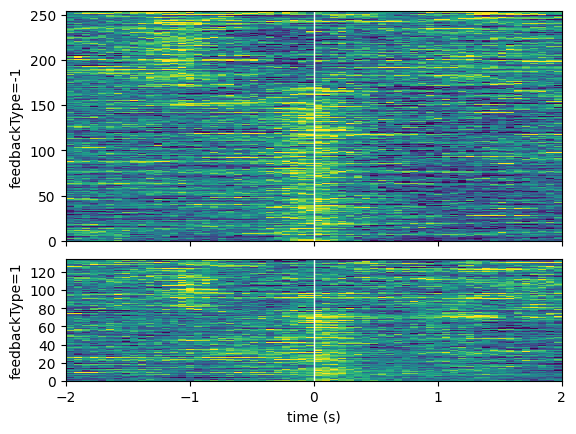

In [ ]:
# psth on reward split by outcome
plots.plot_psth(photometry[brain_regions[0]], trials, event='feedback_times', split_by='feedbackType')